## Cross-correlation exmple with Active-Provenance in dispel4py:



### Sample Corss-Correlation Workflow: Description and Components
<br/>

The workflow performs and visualises the cross correlation matrix between a configurable number of sources, with parametrisable sampling-rate and length of the message.

The workflow specification and especially its parametrisation are inspired by the following research paper:
https://www.cs.ubc.ca/~hoos/Publ/RosEtAl07.pdf

#### Components
<br/>

<li>1 - Class Start: Root node of the graph. It sends initial configruation parameters (Number of total number produced) </li>
<li>2 - Class Source: Produces random number from 0,100 at a specified sampling-rate</i>
<li>3 - Class CorrCoef: Calculates the Pearson's correlation coefficient of a specified amount of samples (batch) coming from two sourcs</li>
<li>4 - Class CompMatrix: Produces and visualises the cross correlation matrix for all Sources for each batch</li>
<li>5 - Class MaxClique: Transfor the correlation matrix into a graph according to a correlation minimum threshold and computes the graph’s max clique</li>

The script below defines the components and declares the workflow. Its execution will show a visual representation of the abstract workfkow grap.


### Function update_prov_state 
Adds an object and its metadata to the PEs state. This can be referenced from the user during write operations, increasing the lineage precision in stateful components.

The accepted parameters are the following:

#### Unnamed parameters:
<li> 1 - <i>name</i>: for references to the provenance StateCollection, a name of the object is required. Using the same name will overwrite the reference</li>
<li> 2 - <i>data</i>: data-object to be stored in the provenance state</li>

#### Named Parameters:
<li> 2 - <i>location</i>: url or path indicating the location of the data file, if any has been produced</li>
<li> 3 - <i>metadata</i>: dictionary of key,values pairs od user-defined metadata associated to the object.</li>
<li> 4 - <i>ignore_inputs</i>: If <b>True</b> the dependencies which are currently standing are ignored. Default: <b>True</b></li>
<li> 5 - <i>dep</i>: a list of look-up terms to retrieve references to <i>DataElements</i> stored by any invocation into the StateCollection. This parameter automatically establishes new <i>wasDerivedFrom</i> relationships</li>
<li> 6 - <i>control</i>: these are actionable instructions like s-prov:skip and s-prov:immediateAccess. These messages are used respectively to selectively discard the production of traces for specific data-stream elements or to trigger their materialisation into a file, to be transferred towards an external target resource.</li>
<li> 7 - <i>messages</i>: developers may identify situations worth to be communicated, like errors or warning, by producing human readable messages.</li>
<li> 8 - <i>format</i>: typically contains the mime-type of the data.</li>


The same contract is availabe for the dispel4py native function <i>write</i>. The difference is that the data-object, instead of being stored, it will be passed to the other components of the workflow through the output port indicated by <i>name</i>.








<br/>


In [90]:
%matplotlib inline

from dispel4py.workflow_graph import WorkflowGraph 
from dispel4py.provenance import *
from dispel4py.new.processor  import *
import time
import random
import numpy
import traceback 
from dispel4py.base import create_iterative_chain, GenericPE, ConsumerPE, IterativePE, SimpleFunctionPE
from dispel4py.new.simple_process import process_and_return

import IPython
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr 
import networkx as nx
from itertools import combinations

sns.set(style="white")


class Start(GenericPE):

    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('iterations')
        self._add_output('output')
        #self.prov_cluster="myne"
    
    def _process(self,inputs):
        
        if 'iterations' in inputs:
            inp=inputs['iterations']
             
            self.write('output',inp,metadata={'iterations':inp})
            
        #Uncomment this line to associate this PE to the mycluster provenance-cluster 
        #self.prov_cluster ='mycluster'

class Source(GenericPE):

    def __init__(self,sr,index,batchsize):
        GenericPE.__init__(self)
        self._add_input('iterations')
        self._add_output('output')
        self.sr=sr
        self.var_index=index
        self.batchsize=batchsize
        #self.prov_cluster="myne"
         
        self.parameters={'sampling_rate':sr,'batchsize':batchsize}
        
        #Uncomment this line to associate this PE to the mycluster provenance-cluster 
        #self.prov_cluster ='mycluster'
        
    
    def _process(self,inputs):
         
        if 'iterations' in inputs:
            iteration=inputs['iterations'][0]
        
        
        batch=[]
        it=1
        #Streams out values at 1/self.sr sampling rate, until iteration>0
        while (it<=iteration):
            while (len(batch)<self.batchsize):
                val=random.uniform(0,100)
                time.sleep(1/self.sr)
                batch.append(val)
                
            self.write('output',(it,self.var_index,batch),metadata={'var':self.var_index,'iteration':it,'batch':batch})
            batch=[]
            it+=1
        

class MaxClique(GenericPE):

    def __init__(self,threshold):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('graph')
        self._add_output('clique')
        self.threshold=threshold
        #self.prov_cluster="myne"
         
        self.parameters={'threshold':threshold}
        
                
        #Uncomment this line to associate this PE to the mycluster provenance-cluster 
        #self.prov_cluster ='mycluster'
        
    
    def _process(self,inputs):
         
        if 'input' in inputs:
            matrix=inputs['input'][0]
            iteration=inputs['input'][1]
        
        
         
       
        
        low_values_indices = matrix < self.threshold  # Where values are low
        matrix[low_values_indices] = 0 
        #plt.figure('graph_'+str(iteration))
        self.write('graph',matrix,metadata={'graph':str(matrix),'batch':iteration})
                
         
        
        H = nx.from_numpy_matrix(matrix)
        
       # labels = {i : i for i in H.nodes()}
       # pos = nx.circular_layout(H)
       # nx.draw_circular(H)
       # nx.draw_networkx_labels(H, pos, labels, font_size=15)
       
        
        cliques = list(nx.find_cliques(H))
        
        fign=0
        maxcnumber=0
        maxclist=[]
        
        for nodes in cliques:
            if (len(nodes)>macxnumber):
                maxcnumber=len(nodes)
                
        for nodes in cliques:
            if (len(nodes)==macxnumber):
                maxclist.append(nodes)

        for nodes in maxclist:    
            edges = combinations(nodes, 2)
            C = nx.Graph()
            C.add_nodes_from(nodes)
            C.add_edges_from(edges)
            fig = plt.figure('clique_'+str(iteration)+str(fign))
            text = "Iteration "+str(iteration)+" "+"clique "+str(fign)
            fign+=1
            labels = {i : i for i in C.nodes()}
            pos = nx.circular_layout(C)
            nx.draw_circular(C)
            nx.draw_networkx_labels(C, pos, labels, font_size=15)
            fig.text(.1,.1,text)
            self.write('cliques',cliques,metadata={'clique':str(nodes),'label':text}, location="file://cliques/")
        
        
        
#        C = nx.make_max_clique_graph(H)
#        plt.figure('clique_'+str(iteration))
#        labels = {i : i for i in C.nodes()}
##        pos = nx.circular_layout(C)
#        nx.draw_circular(C)
#        nx.draw_networkx_labels(C, pos, labels, font_size=15)
         
       
        #Streams out values at 1/self.sr sampling rate, until iteration>0
        
        

class CompMatrix(GenericPE):

    def __init__(self,variables_number):
        GenericPE.__init__(self)
        self._add_input('input',grouping=[0]) 
        self._add_output('output')
        self.size=variables_number
        self.parameters={'variables_number':variables_number}
        self.data={}
         
        
        #Uncomment this line to associate this PE to the mycluster provenance-cluster 
        #self.prov_cluster ='mycluster'self.prov_cluster='mycluster'
            
    def _process(self,inputs):
        for x in inputs:
            
            if inputs[x][0] not in self.data:
                #prepares the data to visualise the xcor matrix of a specific batch number.
                self.data[inputs[x][0]]={}
                self.data[inputs[x][0]]['matrix']=numpy.identity(self.size)
                self.data[inputs[x][0]]['ro_count']=0
            
            self.data[inputs[x][0]]['matrix'][inputs[x][1][0],inputs[x][1][1]]=inputs[x][2]
            self.data[inputs[x][0]]['ro_count']+=1
            #self.log((inputs[x][0],self.data[inputs[x][0]]['ro_count']))
            self.update_prov_state('iter_'+str(inputs[x][0]),None,metadata={'iter_'+str(inputs[x][0]):inputs[x][1]},dep=['iter_'+str(inputs[x][0])])
            
            if self.data[inputs[x][0]]['ro_count']==(self.size*(self.size-1))/2:
                matrix=self.data[inputs[x][0]]['matrix']
                
                d = pd.DataFrame(data=matrix,
                 columns=range(0,self.size),index=range(0,self.size))
                
                mask = numpy.zeros_like(d, dtype=numpy.bool)
                mask[numpy.triu_indices_from(mask)] = True

                # Set up the matplotlib figure
                f, ax = plt.subplots(figsize=(11, 9))

                # Generate a custom diverging colormap
                cmap = sns.diverging_palette(220, 10, as_cmap=True)

                # Draw the heatmap with the mask and correct aspect ratio
                sns.heatmap(d, mask=mask, cmap=cmap, vmax=1,
                    square=True,
                    linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
                
                sns.plt.show()   
                self.log(matrix)
                self.write('output',(matrix,inputs[x][0]),metadata={'matrix':str(d),'iteration':str(inputs[x][0])},dep=['iter_'+str(inputs[x][0])])


            
class CorrCoef(GenericPE):

    def __init__(self):
        GenericPE.__init__(self)
        #self._add_input('input1',grouping=[0])
        #self._add_input('input2',grouping=[0])
        self._add_output('output')
        self.data={}
        
        
         
        
    def _process(self, inputs):
        index=None
        val=None
              
        for x in inputs:
            if inputs[x][0] not in self.data:
                self.data[inputs[x][0]]=[]
                
            for y in self.data[inputs[x][0]]:
                #self.log([y,self.data])
                ro=numpy.corrcoef(y[1],inputs[x][2])
                #self.log(((inputs[x][0],(y[0],inputs[x][1]),ro[0][1])))
                self.write('output',(inputs[x][0],(y[0],inputs[x][1]),ro[0][1]),metadata={'iteration':inputs[x][0],'vars':(y[0],inputs[x][1]),'ro':ro[0][1]},dep=['var_'+str(y[0])])
            
            
            
            #appends var_index and value
            self.data[inputs[x][0]].append((inputs[x][1],inputs[x][2]))
            #self.log(self.data[inputs[x][0]])
            self.update_prov_state('var_'+str(inputs[x][1]),None,metadata={'var_'+str(inputs[x][1]):inputs[x][2]}, ignore_inputs=False)
            
     
 





### Preparing workflow inputs and parameters

<b>number of visualisations</b> = <i>iterations/batch_size</i> at speed defined by the <i>sampling_rate<i>

SETTING NAME: CompMatrix
SETTING NAME: MaxClique
SETTING NAME: Start
SETTING NAME: CorrCoef
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source


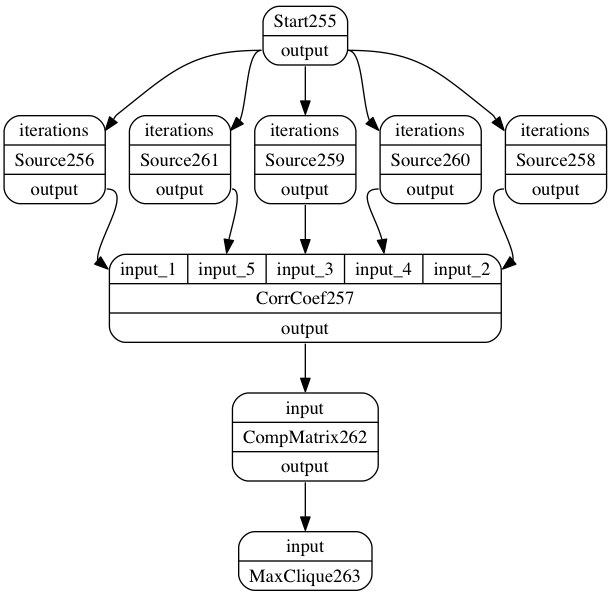

Preparing for: 1 projections


In [91]:
#####################################################################################################

#Declare workflow inputs: (each iteration prduces a batch_size of samples at the specified sampling_rate)
# number of projections = iterations/batch_size at speed defined by sampling rate
variables_number=5
sampling_rate=100
batch_size=5
iterations=5

input_data = {"Start": [{"iterations": [iterations]}]}
      
# Instantiates the Workflow Components  
# and generates the graph based on parameters

def createWf():
    graph = WorkflowGraph()
    mat=CompMatrix(variables_number)
    mat.prov_cluster='record2'
    mc = MaxClique(-0.01)
    mc.prov_cluster='record0'
    start=Start()
    start.prov_cluster='record0'
    sources={}
     

    
    
    cc=CorrCoef()
    cc.prov_cluster='record1'
    
      
    for i in range(0,variables_number):
        sources[i] = Source(sampling_rate,i,batch_size)
        sources[i].prov_cluster='record0'
        #'+str(i%variables_number)
        #+str(i%7)
        sources[i].numprocesses=1
        #sources[i].name="Source"+str(i)

    for h in range(0,variables_number):
        cc._add_input('input'+'_'+str(h+1),grouping=[0])
        graph.connect(start,'output',sources[h],'iterations')
        graph.connect(sources[h],'output',cc,'input'+'_'+str(h+1))
        
    
    graph.connect(cc,'output',mat,'input')
    graph.connect(mat,'output',mc,'input')
    
        
  
    return graph
        

graph=createWf()
#Visualise the graph
from dispel4py.visualisation import display
display(graph)

print ("Preparing for: "+str(iterations/batch_size)+" projections" )

### Execution without provenance
The followin instruction executes the workflow in single-process mode with no provenance
<br/>

SETTING NAME: SimpleProcessingPE


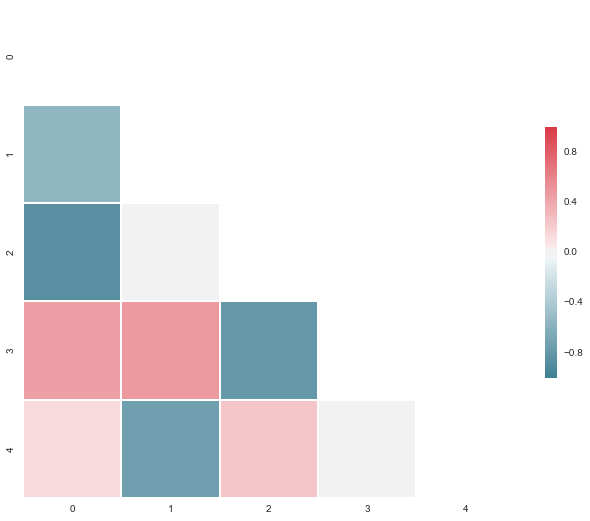

CompMatrix262: [[ 1.          0.          0.          0.          0.        ]
 [-0.54902295  1.          0.06527719  0.          0.        ]
 [-0.85325116  0.          1.          0.          0.        ]
 [ 0.44710103  0.48406731 -0.7859492   1.         -0.74668841]
 [ 0.12908292 -0.72970813  0.23543562  0.          1.        ]]


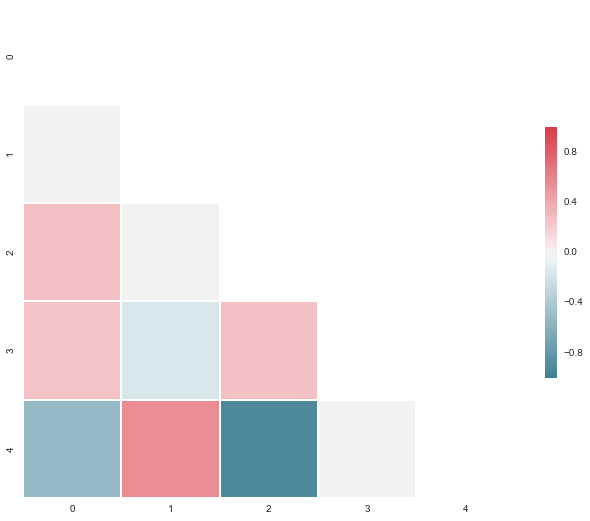

CompMatrix262: [[ 1.          0.          0.          0.          0.        ]
 [-0.00517348  1.         -0.48202938  0.          0.        ]
 [ 0.27489744  0.          1.          0.          0.        ]
 [ 0.26531187 -0.15676015  0.26641661  1.         -0.5124239 ]
 [-0.53047335  0.55149072 -0.91785592  0.          1.        ]]


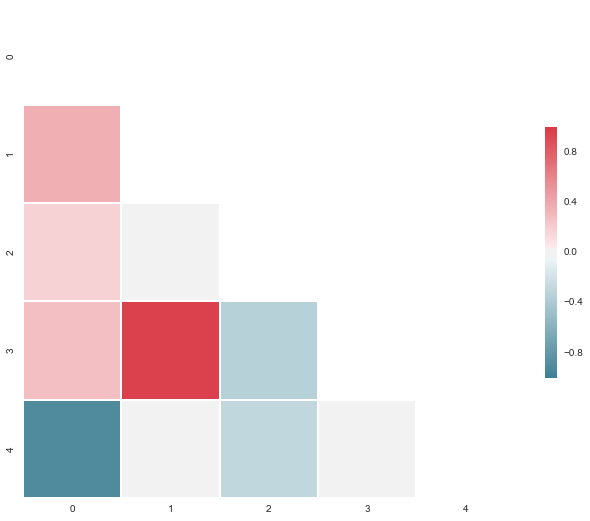

CompMatrix262: [[ 1.          0.          0.          0.          0.        ]
 [ 0.36636223  1.         -0.48438144  0.          0.        ]
 [ 0.17967071  0.          1.          0.          0.        ]
 [ 0.27404465  0.95885717 -0.34086057  1.          0.15048379]
 [-0.90236127  0.01013765 -0.28141709  0.          1.        ]]


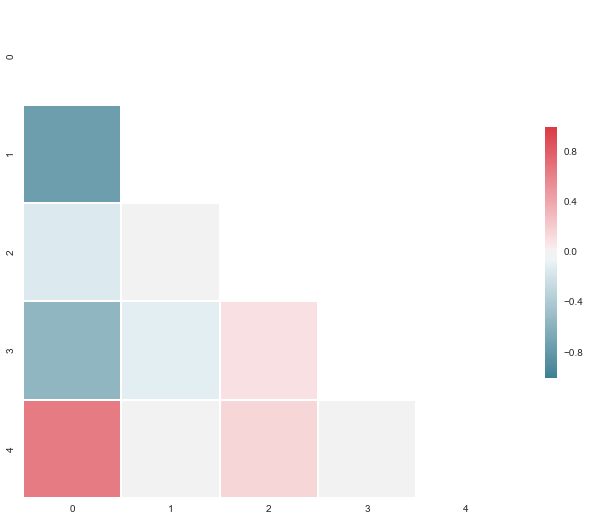

CompMatrix262: [[ 1.          0.          0.          0.          0.        ]
 [-0.74391809  1.          0.23308191  0.          0.        ]
 [-0.13849995  0.          1.          0.          0.        ]
 [-0.54925445 -0.10219415  0.08921069  1.         -0.813432  ]
 [ 0.64809409 -0.00472339  0.15045474  0.          1.        ]]


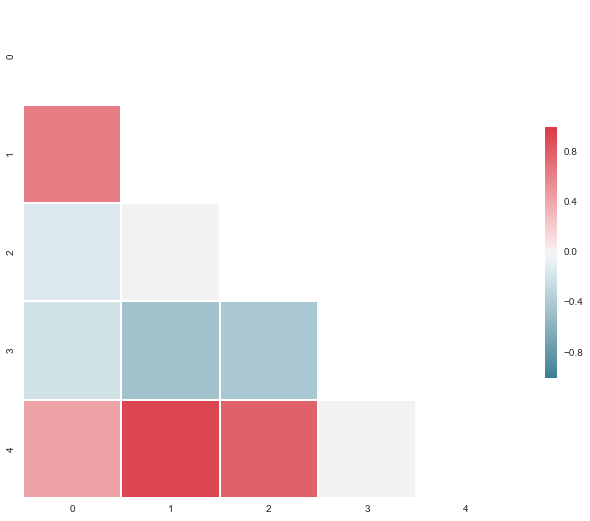

CompMatrix262: [[ 1.          0.          0.          0.          0.        ]
 [ 0.63766779  1.          0.52954512  0.          0.        ]
 [-0.14425655  0.          1.          0.          0.        ]
 [-0.19915611 -0.45050528 -0.41117247  1.         -0.543255  ]
 [ 0.43502563  0.93686416  0.7845392   0.          1.        ]]


NameError: global name 'macxnumber' is not defined

In [92]:
#Launch in simple process
start_time = time.time()
process_and_return(graph, input_data)
elapsed_time = time.time() - start_time
print ("ELAPSED TIME: "+str(elapsed_time))

## Preparing the workflow graph for provenance production, pre-analysis and storage

This snippet will make sure that the workflow compoentns will be provenance-aware and the lineage information sent to the designated ProvenanceRecorders for in-workflow pre-analysis.

The execution will show a new graph where it will be possible to validate the provenance-cluster, if any, and the correct association of ProvenanceRecorders and feedback connections.

The graph will change according to the declaration of self.prov_cluster property of the processing elements and to the specification of different ProvenanceRecorders and feedback loops, as described below:

### Function profile_prov_run 
Prepares the workflow with the required provenance mechanisms
The accepted parameters are the following:

#### Unnamed parameters:
<li> 1 - <i>worfklow graph</i></li>
<li> 2 - Class name implementing the default <i>ProvenanceRecorder</i></li>

#### Named Parameters
<li> 3 - <i>provImpClass</i>: Class name extending the default <i>ProvenancePE</i>. The current type of the workflow components (GenericPE) will be extended with the one indicated by the <i>provImpClass</i> type</li>
<li> 4 - <i>username</i></li>
<li> 5 - <i>runId</i></li>
<li> 6 - <i>w3c_prov</i>: specifies if the PE will outupt lineage in PROV format (default=False)</li>
<li> 7 - <i>workflowName</i></li>
<li> 8 - <i>workflowId</i></li>
<li> 9 - <i>clustersRecorders</i>: dictionary associating <i>provenance-clusters</i> with a specific 
<li> 9 - <i>componentsType</i>: dictionary associating <i>PEs</i> with a specific 
<i>ProvenanceType</i> (overrides the default <i>provImpClass</i>) </li>
<li> 10 - <i>feedbackPEs</i>: list of PE names receiving and processing feedbacks from the <i>ProvenanceRecorder</i>. </li>
<li> 11 - <i>save_mode</i>: specifies if provenance has to be sent to service, stored to file or sent to a sensor for processing and/or storage.</li>

<br/>

#### Provenance Types

Below we define a Class <i>ProvenanceStock</i> that defines the provenance properties that we will assign to the <i>Source</i> PEs. The <i>extractItemMetadata</i> produces the dictionary (list of dictionaries) to be stored as contextual metadata for each element of the computation. 

A provenance type can be also used to create high level abstractions based on the data produced.

For instance, the following type aggreates the outputs produced from a <i>Source</i> in a single trace every 4 samples, reducing the provenance output and introducing a high level abstraction on the actual computation. The <i>provon</i> attribute tells the system if the traces should be produced or not.

These traces may be less precise, but are useful to produce summaries and to reduce the provenance overhead.



In [89]:



class ProvenanceStock(ProvenancePE):
    def __init__(self):
        ProvenancePE.__init__(self)
        self.streammeta=[]
        self.count=1
    
    
    
        def makeUniqueId(self,**kwargs):

            #produce the id
            id=str(uuid.uuid1())

            #Store here the id into the data (type specific):
            if 'data' in kwargs:
                data=kwargs['data']

            #Return
            return id


        def extractExternalInputDataId(self,data):

            #Extract here the id from the data (type specific):
            id = str(uuid.uuid1(str(data)))

            #Return
            return id
        
    
    
        
    
    
    def extractItemMetadata(self,data,port):
        try:
            metadata=None
            self.embed=True
            self.streammeta.append({'val':str(data)})
             
            if (self.count%1==0):
                
                metadata=deepcopy(self.streammeta)
                self.provon=True
                self.streammeta=[]
            else:
                self.provon=False
            
            self.count+=1
            return metadata
                
                 

        except Exception, err:
            self.log("Applying default metadata extraction:"+str(traceback.format_exc()))
            self.error=self.error+"Extract Metadata error: "+str(traceback.format_exc())
            return super(ProvenanceStock, self).extractItemMetadata(data,port);
            
        
   


SETTING NAME: CompMatrix
SETTING NAME: MaxClique
SETTING NAME: Start
SETTING NAME: CorrCoef
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source
Change grouping implementation 
Change grouping implementation 
Injecting provenance to: CompMatrix Original type: (<class 'dispel4py.core.GenericPE'>,)
SETTING NAME: ProvenancePE
Injecting provenance to: CompMatrix Transoformed: (<class 'dispel4py.provenance.ProvenancePE'>, <class '__main__.CompMatrix'>)
Change grouping implementation 
Injecting provenance to: CorrCoef Original type: (<class 'dispel4py.core.GenericPE'>,)
SETTING NAME: ProvenancePE
Injecting provenance to: CorrCoef Transoformed: (<class 'dispel4py.provenance.ProvenancePE'>, <class '__main__.CorrCoef'>)
Change grouping implementation 
Injecting provenance to: MaxClique Original type: (<class 'dispel4py.core.GenericPE'>,)
SETTING NAME: SingleInvocationStateDep
Injecting provenance to: MaxClique Transoformed: (<class 'dispel4py.

Traceback (most recent call last):
  File "dispel4py/provenance.py", line 1288, in buildDerivation
    data['id'], 'TriggeredByProcessIterationID':
TypeError: string indices must be integers, not str


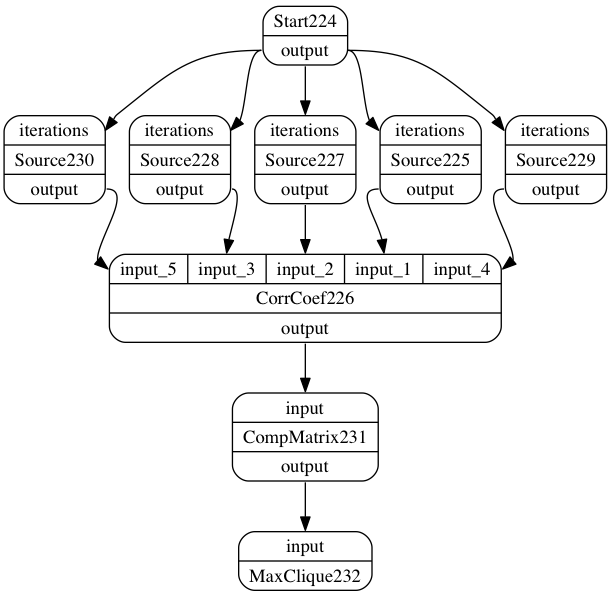

In [77]:

#Store via recorders or sensors
#ProvenanceRecorder.REPOS_URL='http://127.0.0.1:8080/j2ep-1.0/prov/workflow/insert'

#Store via service
ProvenancePE.REPOS_URL='http://127.0.0.1:8082/workflow/insert'

#Export data lineage via service (REST GET Call on dataid resource)
ProvenancePE.PROV_EXPORT_URL='http://127.0.0.1:8082/workflow/export/data/'

#Store to local path
ProvenancePE.PROV_PATH='./prov-files/'

#Size of the provenance bulk before sent to storage or sensor
ProvenancePE.BULK_SIZE=1

#ProvenancePE.REPOS_URL='http://climate4impact.eu/prov/workflow/insert'
 

def createGraphWithProv():
    
    graph=createWf()
    #Location of the remote repository for runtime updates of the lineage traces. Shared among ProvenanceRecorder subtypes

    # Ranomdly generated unique identifier for the current run
    rid='CORR_LARGE_'+getUniqueId()

    
    # Finally, provenance enhanced graph is prepared:   
   
    #Initialise provenance storage end associate a Provenance type with specific components:
    profile_prov_run(graph,None, provImpClass=(ProvenancePE,),
                     username='aspinuso',
                     runId=rid,
                     input=[{'name':'variables_number','url':variables_number},
                            {'name':'sampling_rate','url':sampling_rate},
                            {'name':'batch_size','url':batch_size},
                            {'name':'iterations','url':iterations}],
                     w3c_prov=False,
                     description="provState",
                     workflowName="test_rdwd",
                     workflowId="xx",
                     componentsType= {'MaxClique':{'type':(SingleInvocationStateDep,),'state_dep_port':'graph'}},
                     save_mode='service')

    #
    return graph


graph=createGraphWithProv()

display(graph)

### Execution with provenance
The followin instruction executes the workflow in single-process mode
<br/>

SETTING NAME: CompMatrix
SETTING NAME: MaxClique
SETTING NAME: Start
SETTING NAME: CorrCoef
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source
Change grouping implementation 
Change grouping implementation 
Injecting provenance to: CompMatrix Original type: (<class 'dispel4py.core.GenericPE'>,)
SETTING NAME: ProvenancePE
Injecting provenance to: CompMatrix Transoformed: (<class 'dispel4py.provenance.ProvenancePE'>, <class '__main__.CompMatrix'>)
Change grouping implementation 
Injecting provenance to: CorrCoef Original type: (<class 'dispel4py.core.GenericPE'>,)
SETTING NAME: ProvenancePE
Injecting provenance to: CorrCoef Transoformed: (<class 'dispel4py.provenance.ProvenancePE'>, <class '__main__.CorrCoef'>)
Change grouping implementation 
Injecting provenance to: MaxClique Original type: (<class 'dispel4py.core.GenericPE'>,)
SETTING NAME: SingleInvocationStateDep
Injecting provenance to: MaxClique Transoformed: (<class 'dispel4py.

Traceback (most recent call last):
  File "dispel4py/provenance.py", line 1288, in buildDerivation
    data['id'], 'TriggeredByProcessIterationID':
TypeError: string indices must be integers, not str
Traceback (most recent call last):



SimplePE: Processed 1 iteration.
Outputs: {}
SETTING NAME: SimpleProcessingPE
Start235: BUILDING INITIAL DERIVATION


  File "dispel4py/provenance.py", line 1288, in buildDerivation
    data['id'], 'TriggeredByProcessIterationID':
TypeError: list indices must be integers, not str


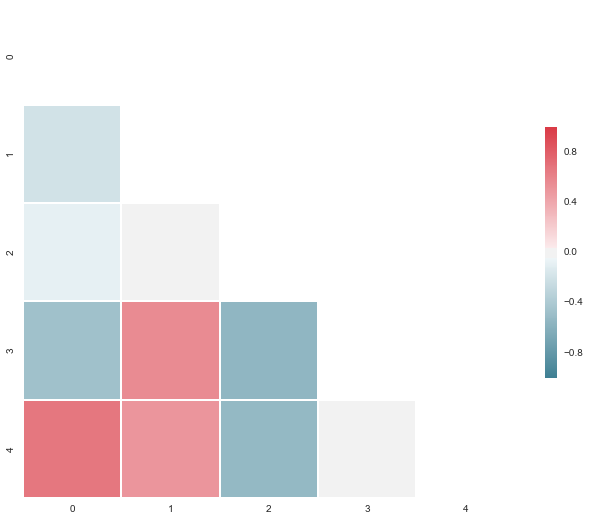

CompMatrix242: [[ 1.          0.          0.          0.          0.        ]
 [-0.19800017  1.         -0.89097302  0.          0.        ]
 [-0.08020968  0.          1.          0.          0.        ]
 [-0.46158791  0.559674   -0.54897252  1.         -0.21120939]
 [ 0.66689383  0.50278624 -0.52365128  0.          1.        ]]


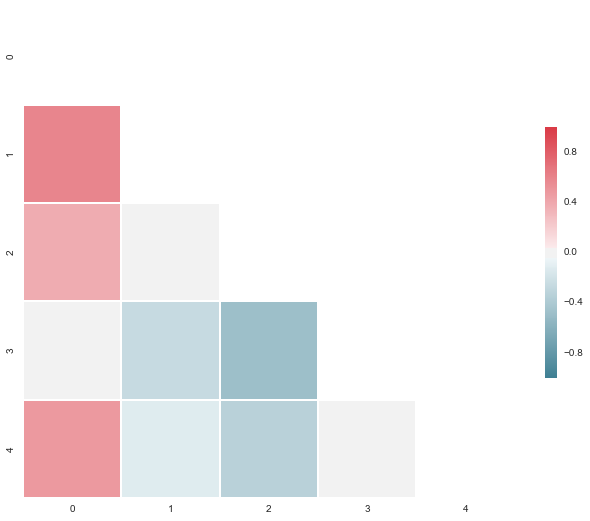

CompMatrix242: [[ 1.          0.          0.          0.          0.        ]
 [ 0.5902076   1.          0.57244137  0.          0.        ]
 [ 0.37541833  0.          1.          0.          0.        ]
 [-0.02122681 -0.26511784 -0.47803432  1.         -0.23309209]
 [ 0.4841824  -0.11943206 -0.33517329  0.          1.        ]]


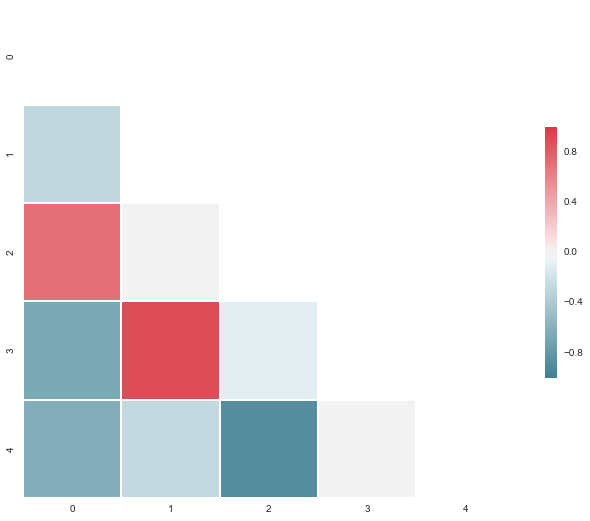

CompMatrix242: [[ 1.          0.          0.          0.          0.        ]
 [-0.28245122  1.          0.17208167  0.          0.        ]
 [ 0.70549875  0.          1.          0.          0.        ]
 [-0.65738034  0.90220091 -0.11676788  1.          0.02030931]
 [-0.62136412 -0.28029524 -0.88136347  0.          1.        ]]


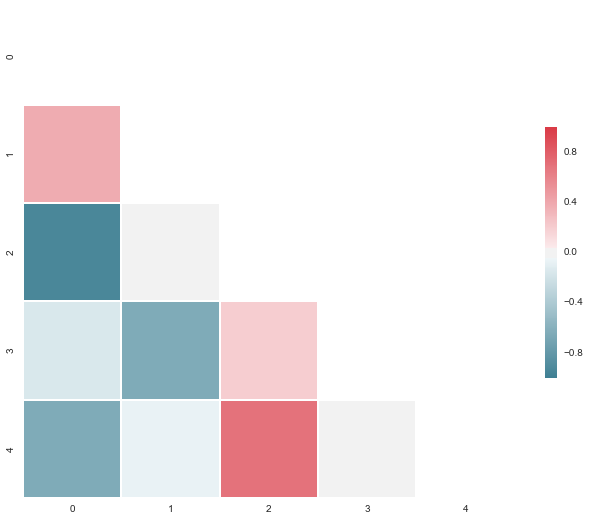

CompMatrix242: [[ 1.          0.          0.          0.          0.        ]
 [ 0.37988007  1.         -0.48077547  0.          0.        ]
 [-0.93245157  0.          1.          0.          0.        ]
 [-0.15326335 -0.64471741  0.20311069  1.          0.43776989]
 [-0.64751808 -0.06376603  0.69177443  0.          1.        ]]


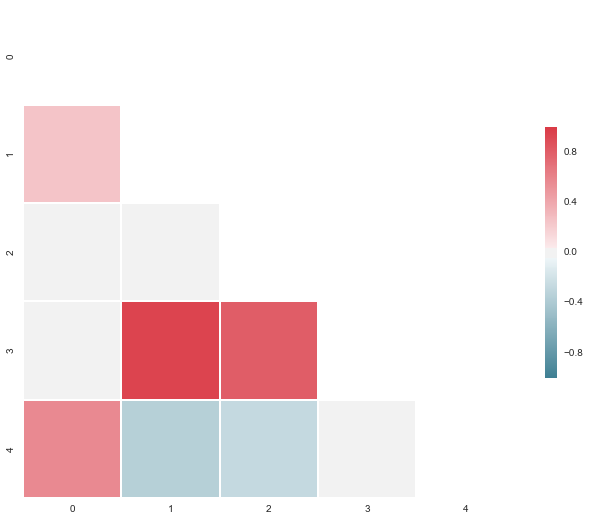

CompMatrix242: [[ 1.          0.          0.          0.          0.        ]
 [ 0.24969975  1.          0.80445575  0.          0.        ]
 [-0.03721639  0.          1.          0.          0.        ]
 [-0.00345999  0.94439756  0.80814745  1.         -0.37782451]
 [ 0.56342922 -0.34644404 -0.26750387  0.          1.        ]]
Start235: Postprocess: (200, 'OK', '{"inserts": ["Start235_stateful_orfeus-as-92002-e00a14eb-7704-11e7-a9fe-f45c89acf865"], "success": true}')
Source240: Postprocess: (200, 'OK', '{"inserts": ["Source240_stateful_orfeus-as-92002-e00ebb14-7704-11e7-914c-f45c89acf865"], "success": true}')
Source241: Postprocess: (200, 'OK', '{"inserts": ["Source241_stateful_orfeus-as-92002-e01486b5-7704-11e7-8810-f45c89acf865"], "success": true}')
Source238: Postprocess: (200, 'OK', '{"inserts": ["Source238_stateful_orfeus-as-92002-e0172019-7704-11e7-9d83-f45c89acf865"], "success": true}')
Source239: Postprocess: (200, 'OK', '{"inserts": ["Source239_stateful_orfeus-as-92002-e019b

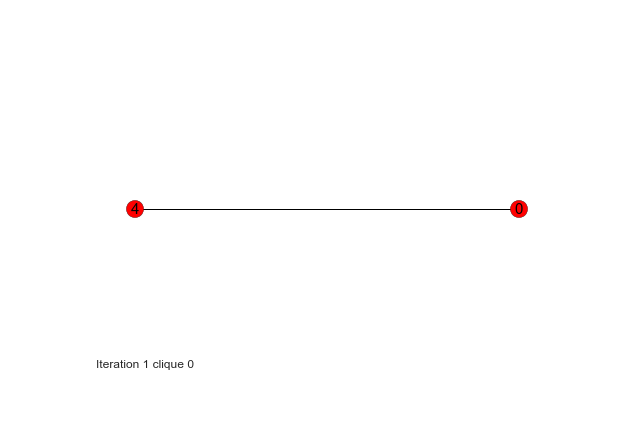

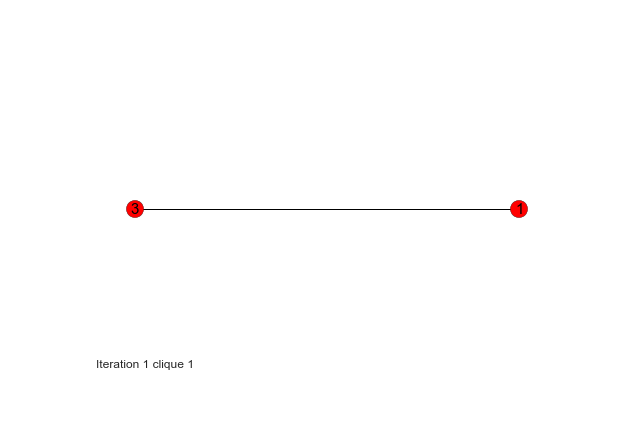

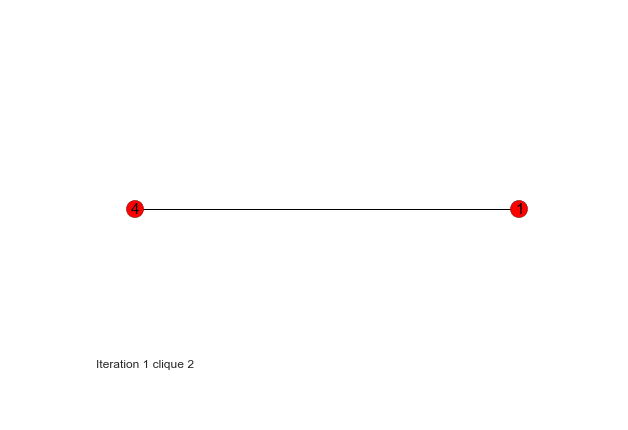

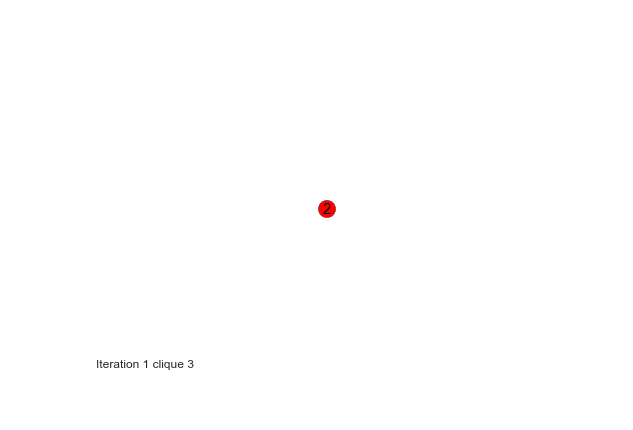

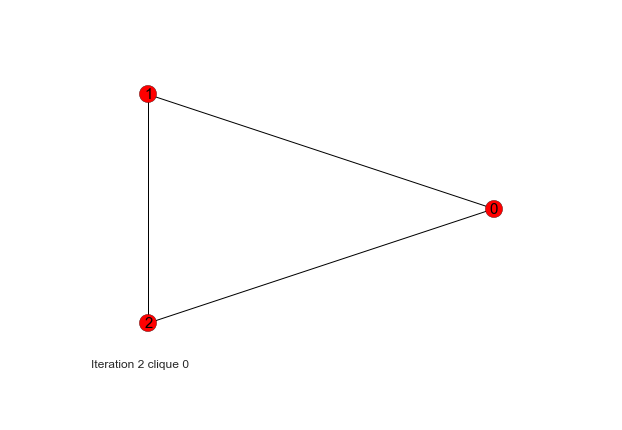

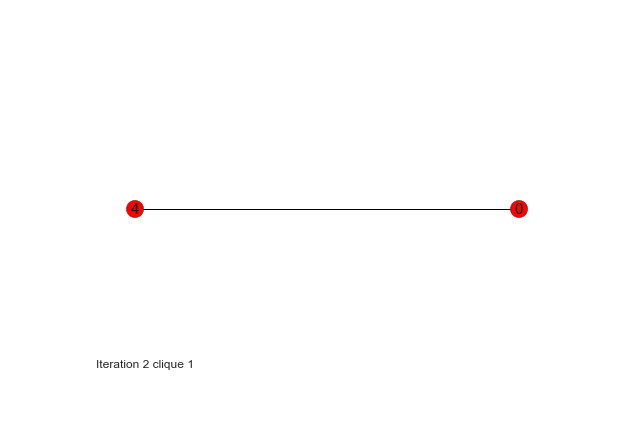

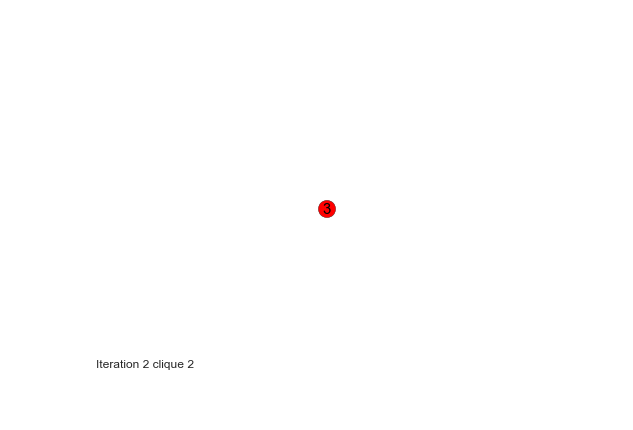

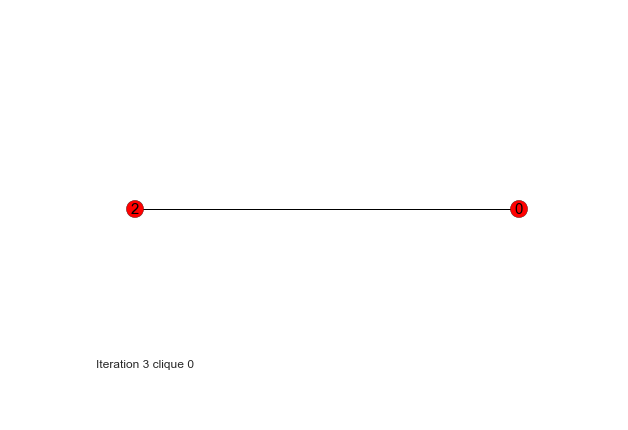

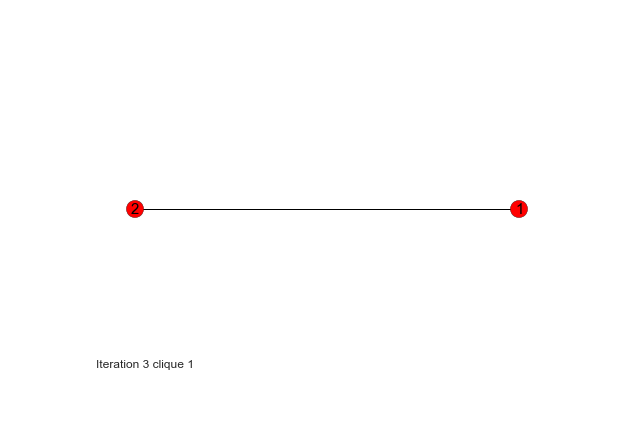

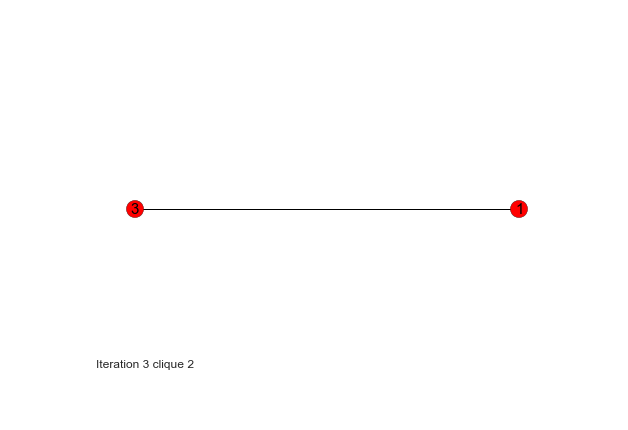

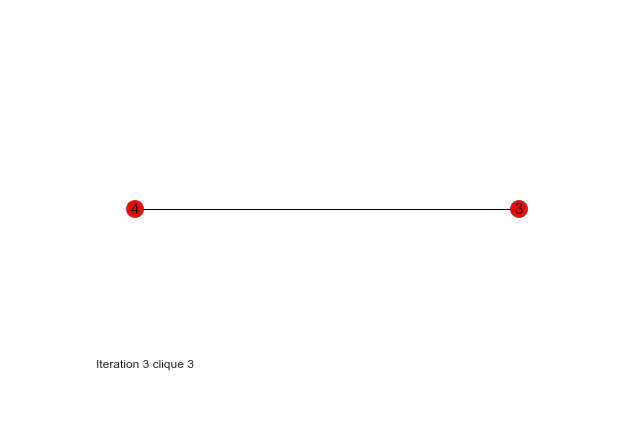

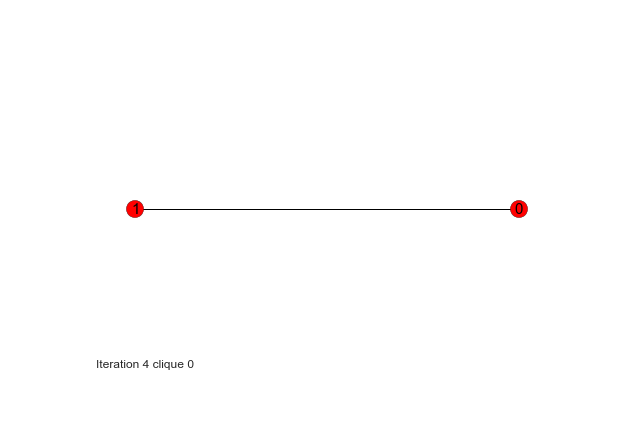

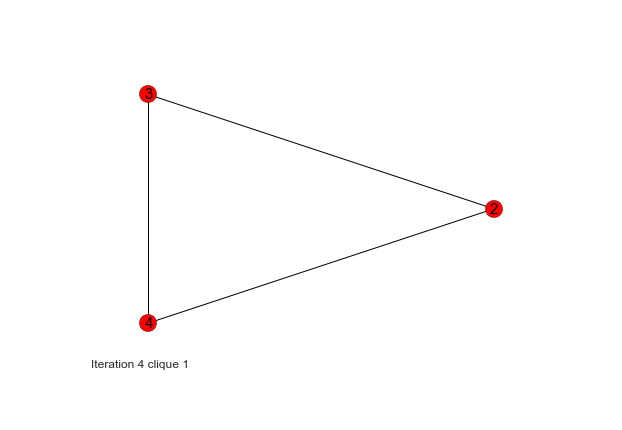

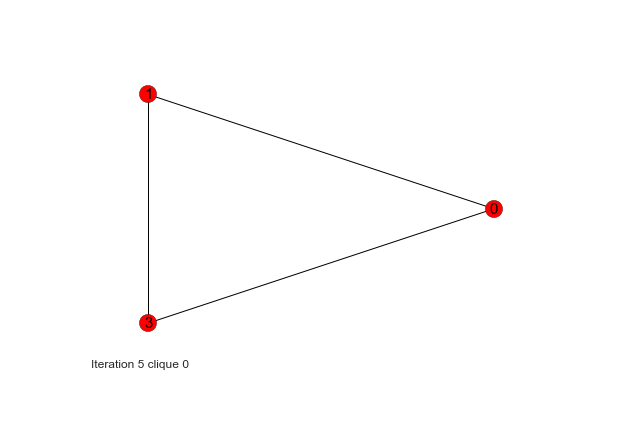

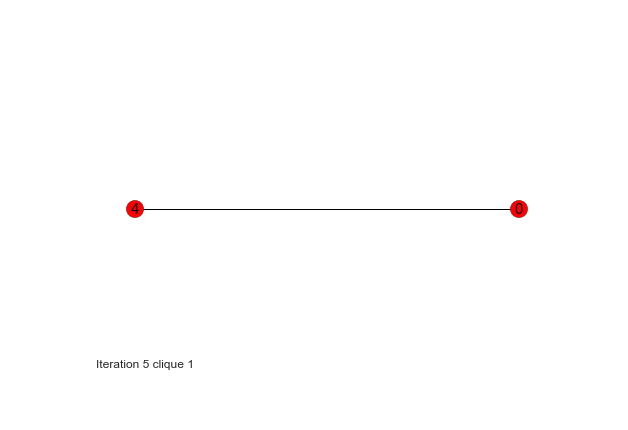

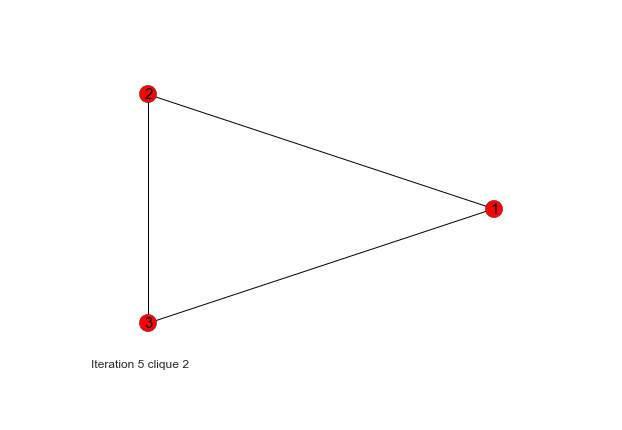

In [78]:
graph = createGraphWithProv()
#Launch in simple process
start_time = time.time()
process_and_return(graph, input_data)
elapsed_time = time.time() - start_time
print ("ELAPSED TIME: "+str(elapsed_time))

## Developing ProvenanceRecorders or Sensors

The Class below show a sample <i>ProvenanceRecorderToService</i> and a slightlty more advanced one that allows for feedback.

### ProvenanceRecorderToService

Recieves traces from the PEs and sends them out to an exteranal provenance store.



In [79]:

class ProvenanceRecorderToService(ProvenanceRecorder):

    def __init__(self, name='ProvenanceRecorderToService', toW3C=False):
        ProvenanceRecorder.__init__(self)
        self.name = name
        self.numprocesses=2
        self.convertToW3C = toW3C
         
    def _postprocess(self):
        self.connection.close()
        
    def _preprocess(self):
        self.provurl = urlparse(ProvenanceRecorder.REPOS_URL)
        self.connection = httplib.HTTPConnection(
            self.provurl.netloc)
        
    def sendToService(self,prov):
        params = urllib.urlencode({'prov': ujson.dumps(prov)})
        headers = {
                    "Content-type": "application/x-www-form-urlencoded",
                    "Accept": "application/json"}
        self.connection.request(
                    "POST",
                    self.provurl.path,
                    params,
                    headers)

        response = self.connection.getresponse()
        self.log("Postprocress: " +
                 str((response.status, response.reason, response)))
        self.connection.close()
        
    def process(self, inputs):
        try:
             
            for x in inputs:
                
                prov = inputs[x]
                
                
                if "_d4p" in prov:
                    prov = prov["_d4p"]
                elif "provenance" in prov:
                    prov = prov["provenance"]
                    
                #self.log(prov)
                self.sendToService(prov)
                
                
        except:
            self.log(traceback.format_exc())





### Provenance Sensor with Feedback - MyProvenanceRecorderWithFeedback

Recieves traces from the PEs and reads its content. Depending from the 'name' of the PE sending the lineage, feedbacks are prepared and sent back.

In [80]:

class MyProvenanceRecorderWithFeedback(ProvenanceRecorder):

    def __init__(self, toW3C=False):
        ProvenanceRecorder.__init__(self)
        self.convertToW3C = toW3C
        self.bulk = []
        self.timestamp = datetime.datetime.utcnow()

    def _preprocess(self):
        self.provurl = urlparse(ProvenanceRecorder.REPOS_URL)

        self.connection = httplib.HTTPConnection(
            self.provurl.netloc)

    def postprocess(self):
        self.connection.close()
        
    def _process(self, inputs):
        prov = None
        for x in inputs:
            prov = inputs[x]
        out = None
        if isinstance(prov, list) and "data" in prov[0]:
            prov = prov[0]["data"]

        if self.convertToW3C:
            out = toW3Cprov(prov)
        else:
            out = prov

            
            
        self.write(self.porttopemap[prov['name']], "FEEDBACK MESSAGGE FROM RECORDER")

        self.bulk.append(out)
        params = urllib.urlencode({'prov': json.dumps(self.bulk)})
        headers = {
            "Content-type": "application/x-www-form-urlencoded",
            "Accept": "application/json"}
        self.connection.request(
            "POST", self.provurl.path, params, headers)
        response = self.connection.getresponse()
        self.log("progress: " + str((response.status, response.reason,
                                         response, response.read())))
        

        return None

## Active provenance with feedback - TBD
Here we show how to implement a PE that can handle feedback from a <i>ProvenanceRecoder</i>. We redefine the worklow graph with the same structure as the provious one but with the new PE



### Preparing the Workflow with provenance clusters and recorders 

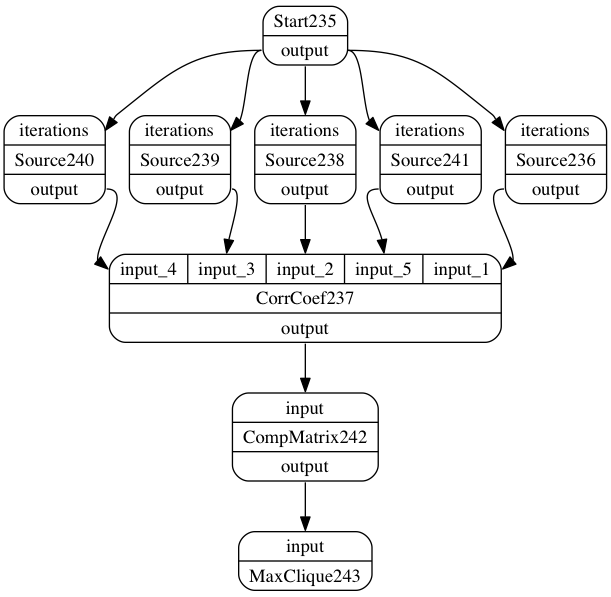

In [81]:

def createGraphWithProv():
    
    graph=createWf()
    #Location of the remote repository for runtime updates of the lineage traces. Shared among ProvenanceRecorder subtypes

    # Ranomdly generated unique identifier for the current run
    rid='JUP_REC_'+getUniqueId()

    #clustersRecorders={'recorder0':ProvenanceRecorderToFileBulk,'recorder0':ProvenanceRecorderToFileBulk,'recorder1':ProvenanceRecorderToFileBulk,'recorder2':ProvenanceRecorderToFileBulk,'recorder3':ProvenanceRecorderToFileBulk,'recorder4':ProvenanceRecorderToFileBulk,'recorder5':ProvenanceRecorderToFileBulk}
    
    #Initialise provenance storage to sensors and service:
    #profile_prov_run(graph,ProvenanceRecorderToService,provImpClass=(ProvenancePE,),username='aspinuso',runId=rid,w3c_prov=False,description="provState",workflowName="test_rdwd",workflowId="xx",save_mode='sensor')
    #clustersRecorders=clustersRecorders,
    
    return graph
#.. and visualised..



# Instantiates the Workflow Components
#graph=createGraphWithProv()

#.. and visualises..

display(graph)

### Execution with provenance recorders
The followin instruction executes the workflow in single-process mode
<br/>

In [82]:
#graph = createGraphWithProv()
#Launch in simple process
start_time = time.time()
#process_and_return(graph, input_data)
#elapsed_time = time.time() - start_time
#print ("ELAPSED TIME: "+str(elapsed_time))

### Extraction from repository of a full provenance trace for a single data-id 

The following instructions connect to the online S-PROV WEB-API and downloads the PROV trace for a single data-id
The trace may be used, for instace, as provenance metadata to embed into the data-file (eg. NetCDF)
<br/>

In [83]:
dataid="orfeus-as-73355-c381c282-d422-11e6-ac42-f45c89acf865"
print("Extract Trace for dataid: "+dataid)

expurl = urlparse(ProvenancePE.PROV_EXPORT_URL)
connection = httplib.HTTPConnection(expurl.netloc)
print(expurl.netloc+expurl.path+dataid+"?all=true")
connection.request(
                "GET", expurl.path+dataid+"?all=true")
response = connection.getresponse()
print("progress: " + str((response.status, response.reason)))
prov = response.read()
print('PROV TO EMBED: '+str(prov))

Extract Trace for dataid: orfeus-as-73355-c381c282-d422-11e6-ac42-f45c89acf865
127.0.0.1:8082/workflow/export/data/orfeus-as-73355-c381c282-d422-11e6-ac42-f45c89acf865?all=true
progress: (500, 'Internal Server Error')
PROV TO EMBED: <html>
  <head>
    <title>Internal Server Error</title>
  </head>
  <body>
    <h1><p>Internal Server Error</p></h1>
    
  </body>
</html>



In [84]:
print("DA")

DA
